# IMU Coarse Calibration using Local Gravity Vector

Notebook to implement and test the *Inertial Navigation Unit* calibration framework presented by:
1. *D. Tedaldi, A. Pretto and E. Menegatti, "A robust and easy to implement method for IMU calibration without external equipments," 2014 IEEE International Conference on Robotics and Automation (ICRA), Hong Kong, China, 2014, pp. 3042-3049, doi: 10.1109/ICRA.2014.6907297.* 

In [34]:
import os
import numpy as np
import pandas as pd
import math

In [35]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = (14,6)

In [36]:
path_data = os.path.join('data/03CalibData.csv' )
headers = ['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

In [37]:
df = pd.read_csv(path_data, names=headers)
df.head()

,time,ax,ay,az,gx,gy,gz
0,1.676365e+09,-890,-456,16409,-121,126,-23
1,1.676365e+09,-890,-456,16452,-120,124,-28
2,1.676365e+09,-875,-439,16466,-117,123,-26
3,1.676365e+09,-848,-434,16472,-119,120,-27
4,1.676365e+09,-844,-447,16469,-121,118,-27


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17698 entries, 0 to 17697
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    17698 non-null  float64
 1   ax      17698 non-null  int64  
 2   ay      17698 non-null  int64  
 3   az      17698 non-null  int64  
 4   gx      17698 non-null  int64  
 5   gy      17698 non-null  int64  
 6   gz      17698 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 968.0 KB


In [39]:
df['time'] = df['time'] - df['time'].loc[0]

In [40]:
# IMU data read through 16-bit signed A/D converter
IMU_MAX = 32767
IMU_MIN = -32768
IMU_RANGE = IMU_MAX - IMU_MIN

# Gyro reads in range +- 150 dps
GYRO_MIN = -250
GYRO_MAX = 250
GYRO_RANGE = GYRO_MAX - GYRO_MIN

# Pull from a local database next
GRAV_MAGNTD = 9.8066

# Accelorometer reads in +- 2g
ACCEL_MIN = -2 * GRAV_MAGNTD
ACCEL_MAX = 2 * GRAV_MAGNTD
ACCEL_RANGE = ACCEL_MAX - ACCEL_MIN

# Sensor Raw (bit) value to physical value
# val = (sensor_raw - IMU_MIN) / IMU_RANGE * sensor_range - sensor_max
for col in ['ax', 'ay', 'az']:
    df[col + '_ms2'] = (df[col] - IMU_MIN) / IMU_RANGE * ACCEL_RANGE + ACCEL_MIN

for col in ['gx', 'gy', 'gz']:
    df[col + '_dps'] = (df[col] - IMU_MIN) / IMU_RANGE * GYRO_RANGE + GYRO_MIN

df.head()

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps
0,0.000000,-890,-456,16409,-121,126,-23,-0.532416,-0.272642,9.822013,-0.919356,0.965133,-0.171664
1,0.009640,-890,-456,16452,-120,124,-28,-0.532416,-0.272642,9.847751,-0.911727,0.949874,-0.209812
2,0.019779,-875,-439,16466,-117,123,-26,-0.523438,-0.262467,9.856131,-0.888838,0.942245,-0.194553
3,0.029934,-848,-434,16472,-119,120,-27,-0.507277,-0.259474,9.859722,-0.904097,0.919356,-0.202182
4,0.040574,-844,-447,16469,-121,118,-27,-0.504882,-0.267255,9.857926,-0.919356,0.904097,-0.202182


In [41]:
(-0.523438 - ACCEL_MIN) / ACCEL_RANGE * IMU_RANGE + IMU_MIN

-875.0005743580841

In [42]:
def windowedVariance(arrAx, arrAy, arrAz, tw=2, fs=100):
    '''
    Calculates windowed variance centered at time 't' for the accelerometer dataset.

    Periods where local variance is high indicate a dynamic state, i.e. rotation, 
    and data in these periods are not used for accelerometer calibration.

    Periods where local variance is ~ 0 indicates a static state, where the IMU readings
    reflect 
    '''
    
    winLen = fs*tw                  # Data Point in Window
    halfWin = int(winLen/2)         # Half window for centered variance
    arrLen = arrAx.size
    
    arrAx = np.copy(arrAx)
    arrAy = np.copy(arrAy)
    arrAz = np.copy(arrAz)

    # Add head and tail to dataset (hold) for windowed methods
    arrAx = np.concatenate((arrAx[0] * np.ones(halfWin), arrAx, arrAx[-1] * np.ones(halfWin)))
    arrAy = np.concatenate((arrAy[0] * np.ones(halfWin), arrAy, arrAx[-1] * np.ones(halfWin)))
    arrAz = np.concatenate((arrAz[0] * np.ones(halfWin), arrAz, arrAy[-1] * np.ones(halfWin)))

    varArr = np.empty(arrLen)

    for i in range(halfWin, arrLen-halfWin):
        varArr[i] = math.sqrt(
                        math.pow(np.var(arrAx[i-halfWin:i+halfWin]),2) + \
                        math.pow(np.var(arrAy[i-halfWin:i+halfWin]),2) + \
                        math.pow(np.var(arrAz[i-halfWin:i+halfWin]),2)
        )
    
    return varArr

In [43]:
%timeit
windwdVarArr = windowedVariance(np.array(df['ax_ms2']), np.array(df['ay_ms2']), np.array(df['az_ms2']))

In [44]:
windwdVarArr

array([1.15674356e-311, 1.15671011e-311, 9.85613055e+000, ...,
       9.89503672e+000, 9.88785404e+000, 9.88426271e+000])

In [45]:
df['windwdVar'] = windwdVarArr
df.head()

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar
0,0.000000,-890,-456,16409,-121,126,-23,-0.532416,-0.272642,9.822013,-0.919356,0.965133,-0.171664,1.156744e-311
1,0.009640,-890,-456,16452,-120,124,-28,-0.532416,-0.272642,9.847751,-0.911727,0.949874,-0.209812,1.156710e-311
2,0.019779,-875,-439,16466,-117,123,-26,-0.523438,-0.262467,9.856131,-0.888838,0.942245,-0.194553,9.856131e+00
3,0.029934,-848,-434,16472,-119,120,-27,-0.507277,-0.259474,9.859722,-0.904097,0.919356,-0.202182,9.859722e+00
4,0.040574,-844,-447,16469,-121,118,-27,-0.504882,-0.267255,9.857926,-0.919356,0.904097,-0.202182,9.857926e+00


In [46]:
df['windwdVar'] = df['windwdVar'].fillna(0)

(0.0, 0.1)

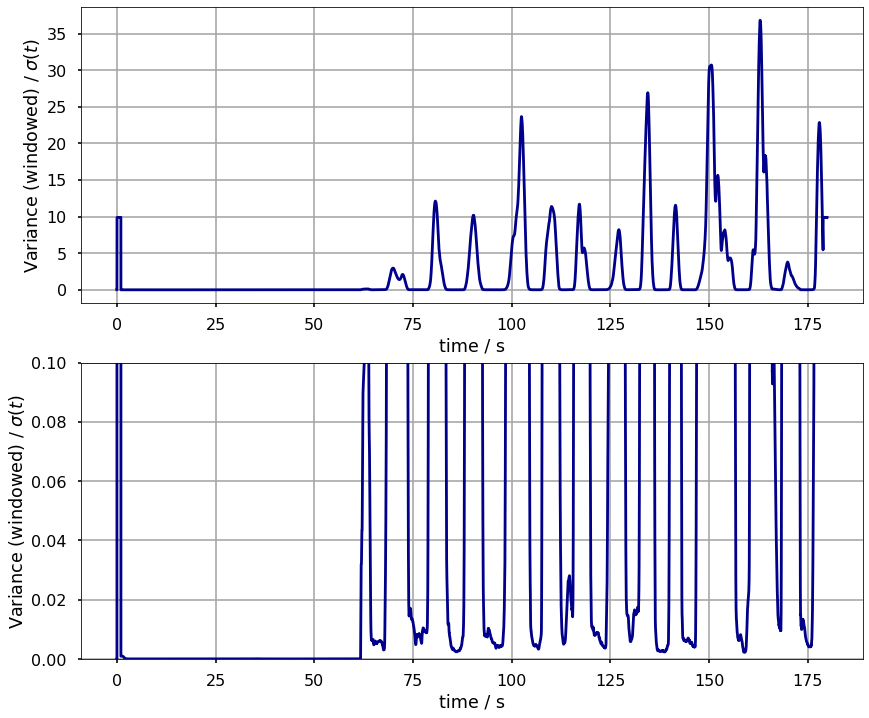

In [47]:
plt.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.plot(df['time'], windwdVarArr, color='darkblue')
plt.grid(True, which='both',ls='-',color='0.65')
plt.ylabel(r'Variance (windowed) / $\sigma(t)$')
plt.xlabel('time / s')

plt.subplot(2,1,2)
plt.plot(df['time'], windwdVarArr, color='darkblue')
plt.grid(True, which='both',ls='-',color='0.65')
plt.ylabel(r'Variance (windowed) / $\sigma(t)$')
plt.xlabel('time / s')
plt.ylim([0, 0.1])

From zoomed in figure above, if $\sigma(t) < 0.01$, assume state is at rest, else assume in motion.

In [48]:
stateGroup = 0                           # Group continous rest states
zeroInbw = False
lastRest = 0

def classifyRestByVar(varValue):
    '''
    Windowed variance value of each row in the IMU dataset is passed in.

    Based on the variance the row is classified as a 'inRest' row or not in rest row.

    The state of the current row and the last row are compared to check for changes in state.

    If no state change has occured, the rows are grouped in the same state group, else, the state group
    is increased, and a new group is started.
    '''
    global lastRest, stateGroup
    inRest = 0
    if varValue < 0.05:
        inRest = 1

    if lastRest != inRest:
        stateGroup +=1
        lastRest = inRest
        
    return (inRest, stateGroup)       

In [49]:
df['inRest'], df['stateGroup'] = zip(*df['windwdVar'].apply(lambda x: classifyRestByVar(x)))

# Not resting is boolean complment of in rest
df['notResting'] = df['inRest'].apply(lambda x: (int(not bool(x))))

(-15.0, 25.0)

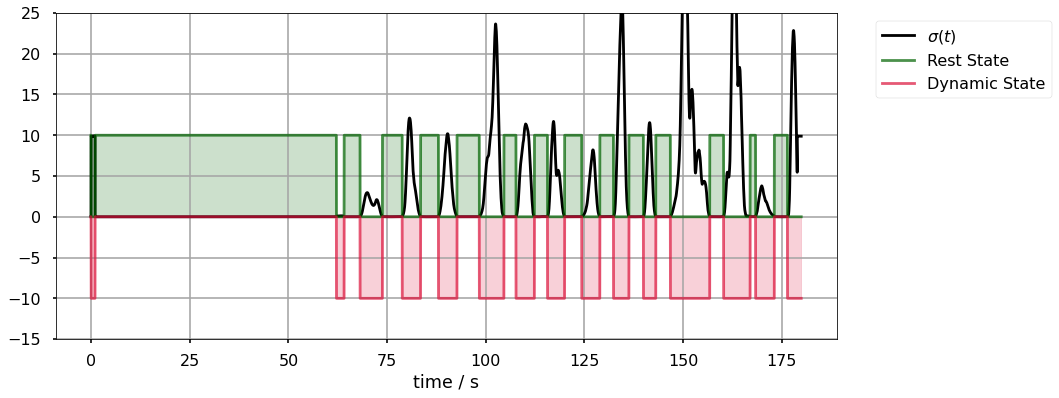

In [50]:
fig, ax = plt.subplots()

ax.plot(df['time'], windwdVarArr, color='k',  label=r'$\sigma(t)$')

ax.plot(df['time'], 10 * df['inRest'], color='darkgreen', alpha=0.7, label='Rest State')
ax.fill_between(df['time'], 0, 10 *df['inRest'], color='darkgreen', alpha=0.2)

ax.plot(df['time'], -10 * df['notResting'], color='crimson', alpha=0.7, label='Dynamic State')
ax.fill_between(df['time'], 0, -10 *df['notResting'], color='crimson', alpha=0.2)

ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.grid(True, which='both',ls='-',color='0.65')
plt.xlabel('time / s')
plt.ylim([-15, 25])

In [51]:
# Crop dataset to remove initial and final variance jumps
df_calb = df[(df['time'] > 50) & (df['time']<177)]

(-15.0, 25.0)

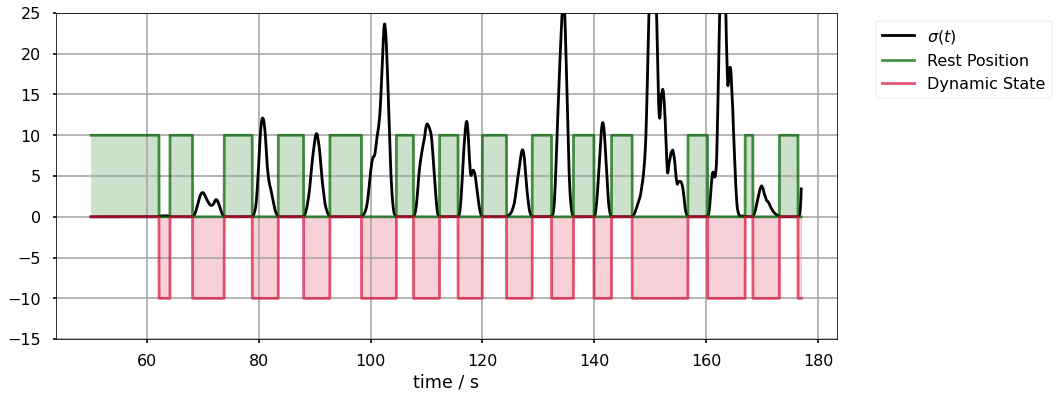

In [52]:
fig, ax = plt.subplots()

ax.plot(df_calb['time'], df_calb['windwdVar'], color='k', label=r'$\sigma(t)$')

ax.plot(df_calb['time'], 10 * df_calb['inRest'], color='darkgreen', alpha=0.7, label='Rest Position')
ax.fill_between(df_calb['time'], 0, 10 *df_calb['inRest'], color='darkgreen', alpha=0.2)

ax.plot(df_calb['time'], -10 * df_calb['notResting'], color='crimson', alpha=0.7,  label='Dynamic State')
ax.fill_between(df_calb['time'], -10 * df_calb['notResting'], color='crimson', alpha=0.2)


ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
plt.grid(True, which='both',ls='-',color='0.65')
plt.xlabel('time / s')
plt.ylim([-15, 25])

From above, roughly 14 rest positions, need atleast 9 unique for 9 unkowns.
1. The rest accelerometer readings are seperated from one another, then each group is average (elimated noise in sensor model)
2. The average vector from each group is added to an aggregate accelerometer matrix.
3. This matrix fed to cost function for least square minimization

In [53]:
# Seperate the rest state dataset from non-rest set
df_rest = df_calb[df_calb['inRest']==1]
df_rest.head(n=2)

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar,inRest,stateGroup,notResting
4918,50.001967,-897,-454,16556,-127,113,-30,-0.536606,-0.271445,9.910001,-0.965133,0.865949,-0.225071,0.00006,1,3,0
4919,50.012117,-894,-462,16547,-131,110,-25,-0.534810,-0.276234,9.904614,-0.995651,0.843061,-0.186923,0.00006,1,3,0


In [54]:
# The average parameters of each rest state
# Indexed by state group
df_rest_avg = df_rest.groupby(['stateGroup']).mean()
df_rest_avg

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar,inRest,notResting
stateGroup,,,,,,,,,,,,,,,,
3,56.075190,-896.611204,-457.128763,16563.806856,-139.180602,122.132107,-36.087793,-0.536373,-0.273318,9.914673,-1.058065,0.935623,-0.271517,0.001160,1.0,0.0
5,66.131370,-1794.068010,-160.319899,16480.874055,-287.065491,172.939547,-65.556675,-1.073552,-0.095661,9.865034,-2.186355,1.323259,-0.496351,0.008483,1.0,0.0
7,76.317484,-1307.512146,-15450.273279,6192.639676,103.307692,80.914980,-32.261134,-0.782321,-9.247562,3.706944,0.792002,0.621156,-0.242322,0.010904,1.0,0.0
9,85.739960,11341.000000,6909.921525,9422.367713,-268.789238,261.984305,-68.618834,6.788529,4.136278,5.640119,-2.046916,2.002627,-0.519713,0.007281,1.0,0.0
11,95.531273,-11138.257194,-5669.444245,11013.690647,-178.647482,97.012590,173.535971,-6.666577,-3.393183,6.592615,-1.359178,0.743973,1.327809,0.008198,1.0,0.0
13,106.121405,9638.647841,-7220.019934,-11316.352159,-102.847176,235.930233,-362.926910,5.769575,-4.321291,-6.773177,-0.780859,1.803847,-2.765140,0.007699,1.0,0.0
15,113.969761,2448.788344,15747.751534,2658.641104,-287.868098,534.822086,-291.920245,1.466037,9.426218,1.591646,-2.192478,4.084246,-2.223394,0.017105,1.0,0.0
17,122.130034,-10084.594848,11591.444965,-5666.358314,-298.641686,216.639344,-244.480094,-6.035900,6.938434,-3.391336,-2.274675,1.656667,-1.861449,0.009435,1.0,0.0
19,130.615717,1494.970588,-423.108824,-16506.797059,47.744118,141.226471,-34.420588,0.895124,-0.252955,-9.879951,0.368079,1.081304,-0.258797,0.014329,1.0,0.0


In [55]:
df_rest_avg.index

Int64Index([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], dtype='int64', name='stateGroup')

In [56]:
accLst = []
for stateGroup in df_rest_avg.index:
    accLst.append([df_rest_avg['ax_ms2'].loc[stateGroup],
                        df_rest_avg['ay_ms2'].loc[stateGroup],
                        df_rest_avg['az_ms2'].loc[stateGroup]])

In [57]:
accMat = np.array(accLst).T

Text(0.5, 0, 'time / s')

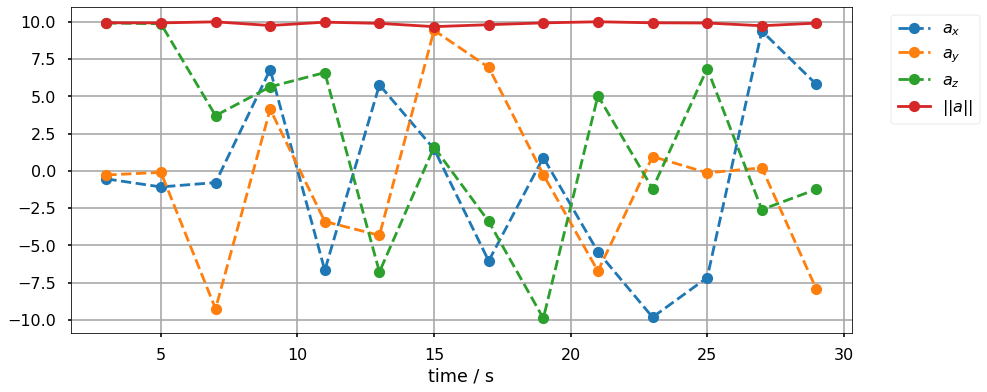

In [58]:
fig, ax = plt.subplots()
ax.plot(df_rest_avg.index, accMat[0], 'o--', label=r'$a_x$' )
ax.plot(df_rest_avg.index, accMat[1], 'o--', label=r'$a_y$')
ax.plot(df_rest_avg.index, accMat[2], 'o--', label=r'$a_z$')
ax.plot(df_rest_avg.index, 
            np.sqrt(np.square(accMat[0])+np.square(accMat[1])+ np.square(accMat[2])), 'o-'
            ,label=r'$||a||$')

ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')
ax.grid(True, which='both',ls='-',color='0.65')
plt.xlabel('time / s')

In [59]:
from scipy.optimize import least_squares

In [63]:
def sensor_measmnt_mdl(ax, ay, az,
                    alpha_xy, alpha_zy, alpha_zx,
                    scale_x, scale_y, scale_z,
                    bias_x, bias_y, bias_z)->np.ndarray:
    N = ax.size
    ax_new = np.empty(ax.size)
    ay_new = np.empty(ax.size)
    az_new = np.empty(ax.size)
    for i in range(N):
        TrnsfrmMat = np.eye(3)
        TrnsfrmMat[0,1] = -1 * alpha_xy
        TrnsfrmMat[0,2] = -1 * alpha_zy
        TrnsfrmMat[1,2] = -1 * alpha_zx
        
        ScaleMat = np.eye(3)
        ScaleMat[0,0] = scale_x
        ScaleMat[1,1] = scale_y
        ScaleMat[2,2] = scale_z
        
        unBiasdVectr = np.array([[ax[i]], [ay[i]], [az[i]]]) - np.array([[bias_x],[bias_y],[bias_z]])  
        _ = np.matmul(np.matmul(TrnsfrmMat, ScaleMat), unBiasdVectr )
        ax_new[i] = _[0]
        ay_new[i] = _[1]
        ax_new[i] = _[2]
        print(np.array([[ax[i]], [ay[i]], [az[i]]]).T, _.T)
    return ax_new, ay_new, az_new

ax, ay, az = accMat[0,:], accMat[0,:], accMat[0,:]
ThetaAcc = [ 0.1, 0.1, 0.1, 0.98, 0.98, 0.98, 0.2, 0.2, 0.2] 
sensor_measmnt_mdl(ax, ay, az,
                    ThetaAcc[0], ThetaAcc[1],ThetaAcc[2],
                    ThetaAcc[3], ThetaAcc[4],ThetaAcc[5],
                   ThetaAcc[6], ThetaAcc[7],ThetaAcc[8])

In [64]:
def loss_functn_accel(ThetaAcc, ax, ay, az):
    ax_new, ay_new, az_new  = sensor_measmnt_mdl(ax, ay, az,
                            ThetaAcc[0], ThetaAcc[1],ThetaAcc[2],
                            ThetaAcc[3], ThetaAcc[4],ThetaAcc[5],
                        ThetaAcc[6], ThetaAcc[7],ThetaAcc[8])
    return 9.808466**2 - (np.square(ax_new) + np.square(ay_new) + np.square(az_new))

In [71]:
accMat

array([[-0.53637318, -1.07355178, -0.78232061,  6.78852851, -6.66657693,
         5.76957456,  1.46603745, -6.03590048,  0.89512364, -5.42813892,
        -9.80978518, -7.15358569,  9.37750541,  5.79514254],
       [-0.27331811, -0.09566124, -9.24756217,  4.1362777 , -3.39318341,
        -4.32129056,  9.42621826,  6.93843397, -0.25295526, -6.71519456,
         0.96287185, -0.12800113,  0.20205243, -7.94293532],
       [ 9.91467348,  9.86503351,  3.70694399,  5.64011869,  6.59261537,
        -6.77317682,  1.59164618, -3.3913363 , -9.87995134,  5.04124924,
        -1.19228014,  6.86355912, -2.59325922, -1.22895272]])

In [73]:
# Start with an initial guess
ThetaAcc = [ 0, 0, 0, 1, 1, 1, 0, 0, 0 ] 
bounds = [(-0.05, -0.05, -0.05, 0.95, 0.95, 0.95, -0.05, -0.05, -0.05), 
            (0.05, 0.05, 0.05, 1.05, 1.05, 1.05, 0.05, 0.05,0.5)]
x = least_squares(loss_functn_accel, ThetaAcc, args=(accMat[:,:-3]), method='lm')

[[-0.53637318 -0.27331811  9.91467348]] [[-0.53637318 -0.27331811  9.91467348]]
[[-1.07355178 -0.09566124  9.86503351]] [[-1.07355178 -0.09566124  9.86503351]]
[[-0.78232061 -9.24756217  3.70694399]] [[-0.78232061 -9.24756217  3.70694399]]
[[6.78852851 4.1362777  5.64011869]] [[6.78852851 4.1362777  5.64011869]]
[[-6.66657693 -3.39318341  6.59261537]] [[-6.66657693 -3.39318341  6.59261537]]
[[ 5.76957456 -4.32129056 -6.77317682]] [[ 5.76957456 -4.32129056 -6.77317682]]
[[1.46603745 9.42621826 1.59164618]] [[1.46603745 9.42621826 1.59164618]]
[[-6.03590048  6.93843397 -3.3913363 ]] [[-6.03590048  6.93843397 -3.3913363 ]]
[[ 0.89512364 -0.25295526 -9.87995134]] [[ 0.89512364 -0.25295526 -9.87995134]]
[[-5.42813892 -6.71519456  5.04124924]] [[-5.42813892 -6.71519456  5.04124924]]
[[-9.80978518  0.96287185 -1.19228014]] [[-9.80978518  0.96287185 -1.19228014]]
[[-0.53637318 -0.27331811  9.91467348]] [[-0.53637318 -0.27331811  9.91467348]]
[[-1.07355178 -0.09566124  9.86503351]] [[-1.0735517

In [74]:
x

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 9651.564014566768
         fun: array([ 23.31016845,  24.01265147, -10.54370901,  50.7782008 ,
        52.08011143,  40.20543551, -12.46236367,  30.29665688,
        23.32518183,  27.419881  ,  93.78504257])
        grad: array([ 0.00000000e+00,  1.95227694e+11, -2.53280395e+02,  2.53280395e+02,
       -2.87612010e+03, -2.05905454e+04, -2.29738109e+00, -4.88317862e+01,
        7.22450281e+02])
         jac: array([[ 0.00000000e+00,  1.74964765e+09, -1.61127799e+00,
         1.61127799e+00, -5.02097903e-02, -1.68780105e+02,
        -1.46148716e-02, -1.81556118e-01,  1.48852274e+01],
       [ 0.00000000e+00,  1.71397823e+09, -1.56532184e-01,
         1.56532184e-01, -1.62430317e-03, -1.67152362e+02,
        -1.41800310e-03, -1.77069438e-02,  1.46487704e+01],
       [ 0.00000000e+00,  7.97535745e+08, -2.81644682e+01,
         2.81644682e+01, -8.18453321e+01,  5.86406981e+01,
        -2.55496833e-01, -8.51477412e+00,  1.3936391

In [36]:
df_calb.head(5)

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar,inRest,stateGroup,notResting
4918,50.001967,-897,-454,16556,-127,113,-30,-0.536606,-0.271445,9.910001,-0.965133,0.865949,-0.225071,0.00006,1,1,0
4919,50.012117,-894,-462,16547,-131,110,-25,-0.534810,-0.276234,9.904614,-0.995651,0.843061,-0.186923,0.00006,1,1,0
4920,50.022343,-896,-449,16558,-129,109,-21,-0.536007,-0.268453,9.911198,-0.980392,0.835431,-0.156405,0.00006,1,1,0
4921,50.032477,-901,-450,16556,-130,113,-23,-0.539000,-0.269051,9.910001,-0.988022,0.865949,-0.171664,0.00006,1,1,0
4922,50.042615,-902,-438,16554,-125,113,-24,-0.539599,-0.261868,9.908804,-0.949874,0.865949,-0.179294,0.00006,1,1,0


In [39]:
df_thea = df_calb[df['stateGroup'] == 2]

C:\Users\Thea\AppData\Local\Temp\ipykernel_15068\2877243501.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_thea = df_calb[df['stateGroup'] == 2]


In [44]:
# Initial ax, ay, az average
df_initAcc = df_rest_avg[df_rest_avg.index==1]

In [45]:
df_initAcc

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar,inRest,notResting
stateGroup,,,,,,,,,,,,,,,,
1,56.07519,-896.611204,-457.128763,16563.806856,-139.180602,122.132107,-36.087793,-0.536373,-0.273318,9.914673,-1.058065,0.935623,-0.271517,0.00116,1.0,0.0


In [40]:
df_thea.head()

,time,ax,ay,az,gx,gy,gz,ax_ms2,ay_ms2,az_ms2,gx_dps,gy_dps,gz_dps,windwdVar,inRest,stateGroup,notResting
6114,62.159734,-720,-956,15414,975,220,-325,-0.430661,-0.571921,9.226449,7.442588,1.682307,-2.475776,0.050326,0,2,1
6115,62.169956,-724,-995,15405,1159,284,-399,-0.433056,-0.595264,9.221062,8.846418,2.170596,-3.040360,0.053094,0,2,1
6116,62.180099,-724,-919,15422,1415,352,-459,-0.433056,-0.549774,9.231238,10.799573,2.689403,-3.498131,0.055888,0,2,1
6117,62.190621,-832,-819,15448,1489,424,-465,-0.497700,-0.489918,9.246800,11.364157,3.238727,-3.543908,0.058571,0,2,1
6118,62.200759,-1086,-763,15415,1487,609,-533,-0.649733,-0.456399,9.227048,11.348898,4.650187,-4.062715,0.061094,0,2,1


In [56]:
#Need to change these values to fit within our code
ax= -0.536373
ay= -0.273318
az= 9.914673
gx= np.pi/180 * np.array(df_thea['gx_dps'])
gy= np.pi/180 * np.array(df_thea['gy_dps'])

g=9.81
theta0 = 0
phi = np.arctan2(-1*az,ay)
theta = np.arcsin(-1*ax/g)
h = 0.2

def drolldt(theta, phi):
    return ((gx*np.cos(theta))+(gy*np.sin(theta)))
 

def rungeKutta(theta0, phi0, theta, h):
    # Count number of iterations using step size or step height h
    n = (int)((theta - theta0)/h)
    # Iterate for number of iterations
    phi = phi0
    for i in range(1, n + 1):
        k1roll = h * drolldt(theta0, phi)
        k2roll = h * drolldt(theta0 + 0.5 * h, phi + 0.5 * k1roll)
        k3roll = h * drolldt(theta0 + 0.5 * h, phi + 0.5 * k2roll)
        k4roll = h * drolldt(theta0 + h, phi + k3roll)
 
        # Update next value of y
        phi = phi + (1.0 / 6.0)*(k1roll + 2 * k2roll + 2 * k3roll + k4roll)
 
        # Update next value of x
        theta0 = theta0 + h
    return phi
print(phi)

-1.5983563679983193


In [ ]:
#Need to change these values to fit within our code, do we need numpy again?
g=9.81
phi0 = 0
theta = np.arcsin(-ax/g)
phi = np.arctan2(-az,ay)
h = 0.2

def dpitchdt(phi, theta):
    return ((gx*np.sin(theta)/np.cos(phi))-(gy*np.cos(theta)/np.cos(phi)))
 

def rungeKutta(phi0, theta0, phi, h):
    # Count number of iterations using step size or step height h
    n = (int)((phi - phi0)/h)
    # Iterate for number of iterations
    theta = theta0
    for i in range(1, n + 1):
        k1pitch = h * drolldt(phi0, theta)
        k2pitch = h * drolldt(phi0 + 0.5 * h, theta + 0.5 * k1pitch)
        k3pitch = h * drolldt(phi0 + 0.5 * h, theta + 0.5 * k2pitch)
        k4pitch = h * drolldt(phi0 + h, theta + k3pitch)
 
        # Update next value of y
        theta = theta + (1.0 / 6.0)*(k1pitch + 2 * k2pitch + 2 * k3pitch + k4pitch)
 
        # Update next value of x
        phi0 = phi0 + h
    return theta